In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/temp-ds-bowl-2019/labels_created
/kaggle/input/temp-ds-bowl-2019/all_users.pkl
/kaggle/input/temp-ds-bowl-2019/df_counter_ini


In [2]:
import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)
        
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
%time df = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv', engine='c')
# labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
df_test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')

df = reduce_mem_usage(df)
# labels = reduce_mem_usage(labels)
df_test = reduce_mem_usage(df_test)
specs = reduce_mem_usage(specs)

CPU times: user 1min 12s, sys: 12.1 s, total: 1min 24s
Wall time: 1min 23s
Mem. usage decreased to 778.73 Mb (18.2% reduction)
Mem. usage decreased to 79.40 Mb (18.2% reduction)
Mem. usage decreased to  0.01 Mb (0.0% reduction)


In [4]:
df_counter = pd.read_feather('/kaggle/input/temp-ds-bowl-2019/df_counter_ini')
#df_counter = pd.read_feather('/kaggle/input/temp-ds-bowl-2019/df_counter')
labels = pd.read_feather('/kaggle/input/temp-ds-bowl-2019/labels_created')


/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_feather(path, columns=columns, nthreads=int_use_threads)
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
all_users = pd.read_pickle('/kaggle/input/temp-ds-bowl-2019/all_users.pkl')

In [6]:
all_users.installation_id.unique().shape, labels.installation_id.unique().shape

((3157,), (3614,))

In [7]:
idx = np.isin(labels.installation_id.unique(), all_users.installation_id.unique())
ids = labels.installation_id.unique()[~idx]

In [8]:
for id, user in df[df.installation_id.isin(labels.installation_id.unique()[~idx])].groupby('installation_id'):
    display(user)
    input()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
11103,27253bdc,fe34349639799cd6,2019-10-05T23:48:27.823Z,"{""event_code"": 2000, ""event_count"": 1}",00225f67,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
11104,27253bdc,f72af986b845f2bb,2019-10-05T23:48:45.299Z,"{""event_code"": 2000, ""event_count"": 1}",00225f67,1,2000,0,Tree Top City - Level 1,Clip,TREETOPCITY
11105,27253bdc,9cefc765ff761b7e,2019-10-05T23:49:11.489Z,"{""event_code"": 2000, ""event_count"": 1}",00225f67,1,2000,0,Ordering Spheres,Clip,TREETOPCITY
11106,b7dc8128,8ba64586223f05ef,2019-10-05T23:49:29.204Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00225f67,1,2000,0,All Star Sorting,Game,TREETOPCITY
11107,4b5efe37,8ba64586223f05ef,2019-10-05T23:49:31.792Z,"{""coordinates"":{""x"":570,""y"":543,""stage_width"":...",00225f67,2,4010,2618,All Star Sorting,Game,TREETOPCITY
...,...,...,...,...,...,...,...,...,...,...,...
12055,499edb7c,6ea72c1a264f2852,2019-10-06T00:11:29.653Z,"{""side"":""left"",""layout"":{""left"":{""chickens"":9,...",00225f67,79,4020,76810,Chicken Balancer (Activity),Activity,CRYSTALCAVES
12056,4bb2f698,6ea72c1a264f2852,2019-10-06T00:11:30.674Z,"{""coordinates"":{""x"":585,""y"":538,""stage_width"":...",00225f67,80,4070,77797,Chicken Balancer (Activity),Activity,CRYSTALCAVES
12057,27253bdc,b178432ed834f847,2019-10-06T00:11:58.982Z,"{""event_code"": 2000, ""event_count"": 1}",00225f67,1,2000,0,Lifting Heavy Things,Clip,CRYSTALCAVES
12058,27253bdc,efb24bced5c91761,2019-10-06T00:12:19.471Z,"{""event_code"": 2000, ""event_count"": 1}",00225f67,1,2000,0,Crystal Caves - Level 2,Clip,CRYSTALCAVES


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [9]:
import gc
gc.collect()

22

# One user

## Prepare data for one user - create attempt and correct

In [10]:
#user_id, user = next(iter(df.groupby('installation_id')))
user_id = 'ea49ea9c'#'29d1aaee' # '3f0dca37'
user = df[df.installation_id == user_id].copy()

totall_attempts = labels[labels.installation_id == user_id].total_attempts.sum()
totall_attempts

74

In [11]:
totall_assessments  = labels[labels.installation_id == user_id].shape[0]
totall_assessments

11

In [12]:
labels[labels.installation_id == user_id]

,game_session,world,type,timestamp,num_correct,total_attempts,installation_id,title,accuracy,num_incorrect,accuracy_group
17,006987623dd64d70,TREETOPCITY,Assessment,2019-10-03 21:09:29.026000+00:00,0,15,ea49ea9c,Bird Measurer (Assessment),0.0,15,0
4809,4656dfff269f9c34,TREETOPCITY,Assessment,2019-10-04 01:18:05.553000+00:00,0,15,ea49ea9c,Bird Measurer (Assessment),0.0,15,0
7086,672887587e2acea0,TREETOPCITY,Assessment,2019-10-04 18:17:55.042000+00:00,0,13,ea49ea9c,Bird Measurer (Assessment),0.0,13,0
7229,694ca296a653c7b1,TREETOPCITY,Assessment,2019-10-04 15:04:29.364000+00:00,0,4,ea49ea9c,Bird Measurer (Assessment),0.0,4,0
8992,82c87eb1c81685e3,TREETOPCITY,Assessment,2019-10-03 23:02:54.805000+00:00,0,4,ea49ea9c,Bird Measurer (Assessment),0.0,4,0
10258,955e711cd3e5bd0c,TREETOPCITY,Assessment,2019-10-06 18:40:13.354000+00:00,0,7,ea49ea9c,Bird Measurer (Assessment),0.0,7,0
10859,9dbef9648774e85a,TREETOPCITY,Assessment,2019-10-04 02:17:18.878000+00:00,0,4,ea49ea9c,Bird Measurer (Assessment),0.0,4,0
11209,a2bd92a6abfec052,TREETOPCITY,Assessment,2019-10-03 21:17:15.638000+00:00,0,6,ea49ea9c,Bird Measurer (Assessment),0.0,6,0
12321,b2f1b3ab52b234ea,TREETOPCITY,Assessment,2019-10-04 01:11:03.733000+00:00,0,4,ea49ea9c,Bird Measurer (Assessment),0.0,4,0
16066,e899df9cb52274df,TREETOPCITY,Assessment,2019-10-06 20:09:36.414000+00:00,0,1,ea49ea9c,Bird Measurer (Assessment),0.0,1,0


In [13]:
user['timestamp'] = pd.to_datetime(user['timestamp'])
print(user.shape)
user.sort_values(by='timestamp').head()

(7431, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
10335411,27253bdc,7fdb9934af897cc3,2019-10-03 00:46:23.617000+00:00,"{""event_code"": 2000, ""event_count"": 1}",ea49ea9c,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
10335412,27253bdc,65518357c7896770,2019-10-03 00:46:41.194000+00:00,"{""event_code"": 2000, ""event_count"": 1}",ea49ea9c,1,2000,0,Tree Top City - Level 1,Clip,TREETOPCITY
10335413,27253bdc,aed2d4e478424bcb,2019-10-03 00:47:11.510000+00:00,"{""event_code"": 2000, ""event_count"": 1}",ea49ea9c,1,2000,0,Ordering Spheres,Clip,TREETOPCITY
10335414,27253bdc,f8051ddc645f89d6,2019-10-03 00:48:45.312000+00:00,"{""event_code"": 2000, ""event_count"": 1}",ea49ea9c,1,2000,0,Ordering Spheres,Clip,TREETOPCITY
10335415,27253bdc,77aeaf07114c22c6,2019-10-03 00:49:15.236000+00:00,"{""event_code"": 2000, ""event_count"": 1}",ea49ea9c,1,2000,0,Ordering Spheres,Clip,TREETOPCITY


In [14]:
user['attempt'] = ((user.type == 'Assessment') &
                       (((user.event_code == 4100) & (user.title != 'Bird Measurer (Assessment)')) |
                        ((user.event_code == 4110)&(user.title == 'Bird Measurer (Assessment)')) )
                   ).astype('int8')
#attempt_idx = user[user.attempt == 1].index
assert user.attempt.sum() == totall_attempts

In [15]:
user['correct'] = 0
user.loc[user.attempt == 1, 'correct'] = user[user.attempt == 1].event_data.str.contains('"correct":true').astype('int8')
#user

### Info for last attemp

In [16]:
def check_data_on_empty(user_data, world, data_type):
    """
    params:
        user_data: dict - dict with data info about user. Keys already exist - installation_id, time_start
        world: str - world of current session
        data_type: str - "type" of current session
    """
    template = world +'_'+ data_type
    user_data[template+'_unique'] = user_data.get(template+'_unique', [])
    user_data[template+'_n_game_session'] = user_data.get(template+'_n_game_session', 0)
    user_data[template+'_event_count'] = user_data.get(template+'_event_count', 0)
    if data_type != 'Clip':
        user_data[template+'_game_time'] = user_data.get(template+'_game_time', 0)
    if  data_type == 'Assessment':
        user_data[world+'_num_correct'] = user_data.get(world+'_num_correct', 0)
        user_data[world+'_num_incorrect'] = user_data.get(world+'_num_incorrect', 0)
    
def get_common_data(session, user_data):
    """
    params: 
        session: DataFrame - one session form groupby('game_session')
        user_data: dict - dict with data info about user. Accumulate all infor for user though attempts.
    return:
        user_results: list - list of dictionaries, one for each attempt of one user
    """
    data_type = session.type.iloc[0]
    world = session.world.iloc[0]
    template = world +'_'+ data_type
    check_data_on_empty(user_data, world, data_type)    
     
    if data_type == 'Assessment' and session.attempt.sum() >= 1:  
        attempt = user_data.copy()
        last_attempt_idx = session[session.attempt ==1].index[-1]
        attempt['last_attempt_world'] = session.world.iloc[0]
        attempt['last_attempt_game_time'] = session.at[last_attempt_idx, 'game_time']
        attempt['last_attempt_event_count'] = session.at[last_attempt_idx, 'event_count']
        
        # to labels
        attempt['num_correct'] = session.correct.sum()
        attempt['num_incorrect'] = session.attempt.sum() - attempt['num_correct']
        
        #print(world, user_data[world+'_num_incorrect'], attempt['num_incorrect'] )
        
        user_data[world+'_num_correct'] += attempt['num_correct'] 
        user_data[world+'_num_incorrect'] += attempt['num_incorrect'] #session.attempt.sum() - user_data[world+'_num_correct']
        #print('2', world, user_data[world+'_num_incorrect'])
        user_results.append(attempt)
        
    elif data_type == 'Assessment'  and session.correct.sum() > 1:
        print(session.game_session.iloc[0], ': game session; # correct attempt > 1')
    
    event_code_counts = session['event_code'].value_counts()
    for i, j in zip(event_code_counts.index, event_code_counts.values):
        user_data[i] = user_data.get(i,0) + j
        
    # add common info, include attempt info for next study
    user_data[template+'_unique'].extend(session.title.unique().tolist())
    user_data[template+'_n_game_session'] += np.unique(session.game_session).shape[0]
    user_data[template+'_event_count'] += session.shape[0]
    if data_type != 'Clip':
        user_data[template+'_game_time'] += session.game_time.max()
    
    return user_results


In [17]:
user_results = []

user_data = {}
user_data['installation_id'] = user.installation_id.iloc[0]
user_data['time_start'] = user.timestamp.iloc[0]

for i, session in user.groupby('game_session', sort=False):
    #print(user_data)
    get_common_data(session, user_data)
    
tt = pd.DataFrame(user_results)

In [18]:
tt

,installation_id,time_start,NONE_Clip_unique,NONE_Clip_n_game_session,NONE_Clip_event_count,2000,TREETOPCITY_Clip_unique,TREETOPCITY_Clip_n_game_session,TREETOPCITY_Clip_event_count,MAGMAPEAK_Clip_unique,...,last_attempt_game_time,last_attempt_event_count,num_correct,num_incorrect,4110,3020,3120,2060,2075,2070
0,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",3,3,94,"[Tree Top City - Level 1, Ordering Spheres, Or...",50,50,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,59426,51,0,15,NaN,NaN,NaN,NaN,NaN,NaN
1,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",3,3,104,"[Tree Top City - Level 1, Ordering Spheres, Or...",57,57,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,30775,22,0,6,15.0,15.0,14.0,NaN,NaN,NaN
2,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,133,"[Tree Top City - Level 1, Ordering Spheres, Or...",75,75,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,17477,14,0,4,21.0,21.0,20.0,NaN,NaN,NaN
3,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,144,"[Tree Top City - Level 1, Ordering Spheres, Or...",82,82,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,16984,14,0,4,25.0,25.0,24.0,NaN,NaN,NaN
4,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,154,"[Tree Top City - Level 1, Ordering Spheres, Or...",88,88,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,135967,52,0,15,29.0,29.0,27.0,NaN,NaN,NaN
5,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,167,"[Tree Top City - Level 1, Ordering Spheres, Or...",95,95,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,16746,14,0,4,44.0,44.0,42.0,NaN,NaN,NaN
6,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,189,"[Tree Top City - Level 1, Ordering Spheres, Or...",109,109,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,17842,14,0,4,48.0,48.0,45.0,NaN,NaN,NaN
7,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,227,"[Tree Top City - Level 1, Ordering Spheres, Or...",132,132,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,63105,48,0,13,52.0,52.0,49.0,1.0,1.0,NaN
8,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,289,"[Tree Top City - Level 1, Ordering Spheres, Or...",167,167,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,28546,25,0,7,65.0,65.0,62.0,2.0,1.0,NaN
9,ea49ea9c,2019-10-03 00:46:23.617000+00:00,"[Welcome to Lost Lagoon!, Welcome to Lost Lago...",4,4,306,"[Tree Top City - Level 1, Ordering Spheres, Or...",176,176,"[Magma Peak - Level 1, Magma Peak - Level 2, M...",...,5047,5,0,1,73.0,72.0,69.0,4.0,2.0,1.0


# Total: for all users

In [19]:
np.isin(labels.installation_id.unique(), df.installation_id.unique()).sum()

3614

In [20]:
all_users = pd.DataFrame()

for n,user_id in enumerate(labels.installation_id.unique()):
    print(n, user_id)
    user = df[df.installation_id == user_id].copy()
    user['timestamp'] = pd.to_datetime(user['timestamp'])
    # user.sort_values(by='timestamp')
    
    user['attempt'] = ((user.type == 'Assessment') &
                       (((user.event_code == 4100) & (user.title != 'Bird Measurer (Assessment)')) |
                        ((user.event_code == 4110)&(user.title == 'Bird Measurer (Assessment)')) )
                   ).astype('int8')
    
    totall_attempts = labels[labels.installation_id == user_id].total_attempts.sum()
    assert user.attempt.sum() == totall_attempts
    
    user['correct'] = 0
    user.loc[user.attempt == 1, 'correct'] = user[user.attempt == 1]\
                                            .event_data.str.contains('"correct":true').astype('int8')

    user_results, user_data = [], {}
    
    user_data['installation_id'] = user.installation_id.iloc[0]
    user_data['time_start'] = user.timestamp.iloc[0]

    for i, session in user.groupby('game_session', sort=False):
        get_common_data(session, user_data)
        
    temp = all_users.shape
    all_users = pd.concat((all_users,pd.DataFrame(user_results)), ignore_index=True, sort=False)
    
    assert all_users.shape > temp, user_id
#     display(all_users)
#     input()
    
    

0 01bdd720
1 3f0dca37
2 29d1aaee
3 55fdf49f
4 19d4b097
5 94c4ed61
6 ba5d06eb
7 daed707d
8 2d6c11a8
9 fd5385c7
10 371a7c29
11 ac5119e4
12 080f9689
13 4b02b17f
14 4287d12e
15 9d3eb33a
16 406ebb06
17 ea49ea9c
18 2c676054
19 7d9d60e6
20 9e579f54
21 3852ab9f
22 d28885da
23 f8065f08
24 63e80d35
25 6ce4da99
26 2e17f66c
27 cf2a3a60
28 88f20d9c
29 c37c1c88
30 2df817bf
31 4ccb19fa
32 0583693e
33 a31288d6
34 cb945fe6
35 8e44d2de
36 b1d58078
37 09296168
38 5d583c6b
39 52518080
40 2cd281b9
41 109a4bce
42 f827f848
43 466a6ad4
44 89754278
45 a64e3ce2
46 4f127057
47 856e7225
48 63f8e904
49 453a7a16
50 464f634a
51 52f9769b
52 57bbe2e1
53 d7c68978
54 4d7392c0
55 d68eabbe
56 5e9f2830
57 5e7aaf29
58 9cefacd0
59 8cd1cf19
60 96bbb0df
61 c6817a41
62 aff2929d
63 6ecb42db
64 051794c4
65 59d9c2e8
66 518a3f1f
67 022183ab
68 99af1ce6
69 a9d4a8a7
70 1b142503
71 072a25ac
72 2505e76e
73 baedce19
74 3ab4f204
75 d792d001
76 14142f8f
77 1e819b97
78 48ca1b10
79 c7f1c288
80 13c26706
81 c60bdeaf
82 eac8abf4
83 72c37629
84

In [21]:
print(all_users.shape)
all_users.installation_id.unique().shape

(17690, 103)


(3614,)

In [22]:
all_users.columns

Index([                 'installation_id',                       'time_start',
                       'NONE_Clip_unique',         'NONE_Clip_n_game_session',
                  'NONE_Clip_event_count',                               2000,
               'CRYSTALCAVES_Clip_unique', 'CRYSTALCAVES_Clip_n_game_session',
          'CRYSTALCAVES_Clip_event_count',         'CRYSTALCAVES_Game_unique',
       ...
       'MAGMAPEAK_Assessment_event_count',   'MAGMAPEAK_Assessment_game_time',
                  'MAGMAPEAK_num_correct',          'MAGMAPEAK_num_incorrect',
                                     4230,                               4235,
                                     4220,                               4050,
                                     4080,                               4090],
      dtype='object', length=103)

In [23]:
all_users.columns = all_users.columns.astype(str)

In [24]:
all_users.to_pickle('all_users.pkl')

# Features names

In [25]:
worlds_columns = []
for world in df_test.world.unique():
    c = tt.columns
    worlds_columns.append([x for x in c if world in x])

TypeError: argument of type 'int' is not iterable

In [26]:
display(tt[['last_attempt_world',
      'num_correct', 'num_incorrect']], labels[labels.installation_id == user_id].sort_values(by='timestamp'))

,last_attempt_world,num_correct,num_incorrect
0,TREETOPCITY,0,15
1,TREETOPCITY,0,6
2,TREETOPCITY,0,4
3,TREETOPCITY,0,4
4,TREETOPCITY,0,15
5,TREETOPCITY,0,4
6,TREETOPCITY,0,4
7,TREETOPCITY,0,13
8,TREETOPCITY,0,7
9,TREETOPCITY,0,1


,game_session,world,type,timestamp,num_correct,total_attempts,installation_id,title,accuracy,num_incorrect,accuracy_group
17675,ffbfa9bef569d593,CRYSTALCAVES,Assessment,2019-09-18 14:03:20.749000+00:00,0,2,a4e62501,Cart Balancer (Assessment),0.0,2,0


# Labels

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='deep')
sns.set_style("dark")

In [28]:
def autolabel(ratio, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for x, t in enumerate(ax.get_xticklabels()):
        f = t.get_text()
        try: f = int(f)
        except: pass
        ax.annotate(f'{ratio[f]:.2f}%',
                    xy=(x, 0),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

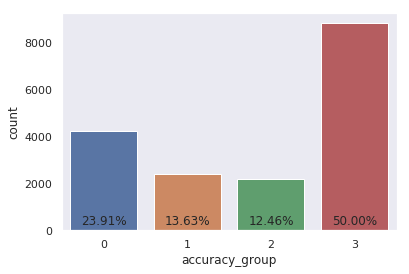

In [29]:
ax = sns.countplot(x='accuracy_group', data=labels);
autolabel(labels.accuracy_group.value_counts()/labels.shape[0]*100, ax)

# Features: title, type and world

In [30]:
# temp.world = temp.world.astype('category')
# print(temp.world.cat.categories)
# temp.world = temp.world.cat.codes

In [31]:
def df_na(df): return print("There aren't NaNs:",  ~df.isna().all(axis=None))

To compare inital train data with out labels, need to group inital data too

In [32]:
df_group = df.groupby('game_session', as_index=False).agg({'world': lambda x: x.iloc[0],
                                            'title': lambda x: x.iloc[0],
                                            'type': lambda x: x.iloc[0]})

Plot ditributions by categories for inital grouped data and labels_created data. Also for lables_created data plt distribution by accuracy_group

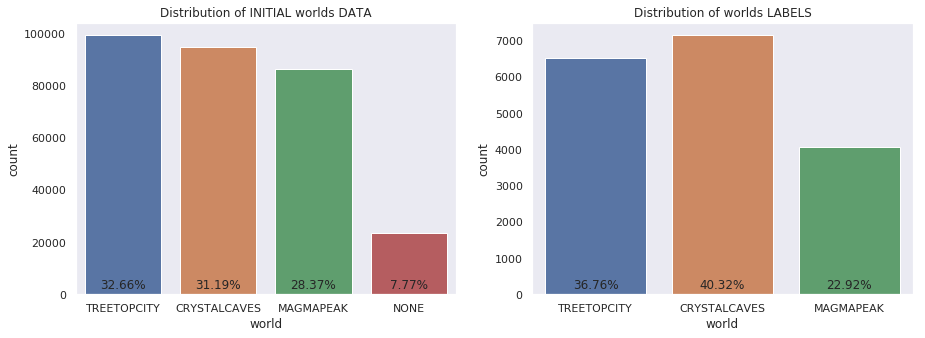

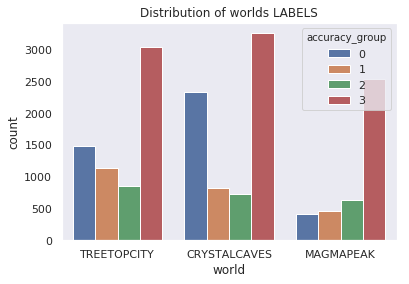

In [33]:
order = labels.world.unique()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='world', data=df_group , order=np.append(order, 'NONE'))
ax.set_title('Distribution of INITIAL worlds DATA')
autolabel(df_group.world.value_counts()/df_group.shape[0]*100, ax)

plt.subplot(1,2,2)
ax = sns.countplot(x='world', data=labels, order=order);
ax.set_title('Distribution of worlds LABELS');
autolabel(labels.world.value_counts()/labels.shape[0]*100, ax)

plt.show()

ax = sns.countplot(x='world', data=labels, hue='accuracy_group', order=order);
ax.set_title('Distribution of worlds LABELS');

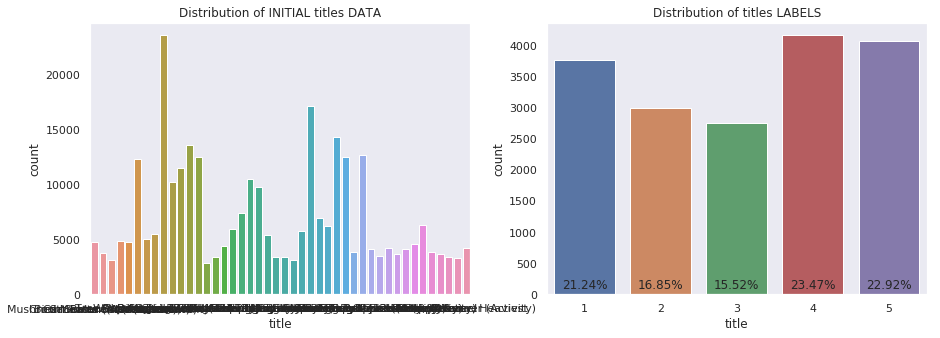

['Mushroom Sorter (Assessment)' 'Chest Sorter (Assessment)'
 'Bird Measurer (Assessment)' 'Cart Balancer (Assessment)'
 'Cauldron Filler (Assessment)']


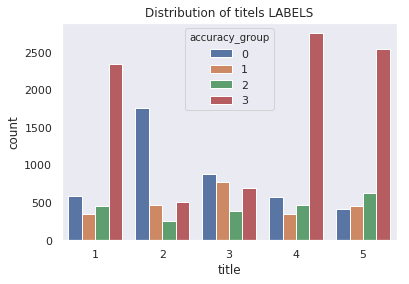

In [34]:
order = labels.title.unique()
leaved_cat = np.isin(df_group.title.unique(), order)
leaved_cat = df_group.title.unique()[~leaved_cat]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='title', data=df_group , order=np.append(order, leaved_cat))
ax.set_title('Distribution of INITIAL titles DATA')
#autolabel(df.title.value_counts()/df.shape[0]*100, ax)

plt.subplot(1,2,2)
ax = sns.countplot(x='title', data=labels, order=order);
ax.set_title('Distribution of titles LABELS');
autolabel(labels.title.value_counts()/labels.shape[0]*100, ax)
ax.set_xticklabels(['1','2','3','4','5'])

plt.show()

ax = sns.countplot(x='title', data=labels, hue='accuracy_group', order=order);
ax.set_title('Distribution of titels LABELS');
ax.set_xticklabels(['1','2','3','4','5']);
print(order)

**Note:** One can see for title 2 = 'Chest Sorter (Assessment)' most of samples have *accuracy_group* = 0 despire *accuracy_group* = 3 is majority class.

In [35]:
title_unique = labels.title.unique()

# counters for each title_name
counter_title = {'title': [lambda x,y=t: np.sum(x==y) for t in title_unique]}
# last title name
counter_title['title'].append(lambda x: x.iloc[-1])

counter_title.update({'game_session':'count',
                      'timestamp': lambda x: x.iloc[-1]})
counter_title

{'title': [<function __main__.<listcomp>.<lambda>(x, y='Mushroom Sorter (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Chest Sorter (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Bird Measurer (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Cart Balancer (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Cauldron Filler (Assessment)')>,
  <function __main__.<lambda>(x)>],
 'game_session': 'count',
 'timestamp': <function __main__.<lambda>(x)>}

In [36]:
columns = ['installation_id', 'title_MS', 'title_CS', 'title_BM', 'title_CB', 'title_CF', 'title_last',
       'n_games', 'timestamp_last']
labels_title = labels.sort_values(by='timestamp').groupby('installation_id', as_index=False)\
                     .agg(counter_title)
labels_title.columns = columns

labels_title.head()

,installation_id,title_MS,title_CS,title_BM,title_CB,title_CF,title_last,n_games,timestamp_last
0,0006a69f,3,0,2,0,0,Bird Measurer (Assessment),5,2019-08-06 20:50:12.115000+00:00
1,0006c192,1,0,1,0,1,Bird Measurer (Assessment),3,2019-10-01 00:59:42.289000+00:00
2,00129856,0,0,1,0,0,Bird Measurer (Assessment),1,2019-09-22 16:32:43.121000+00:00
3,001d0ed0,2,1,1,1,0,Chest Sorter (Assessment),5,2019-09-05 14:29:12.756000+00:00
4,00225f67,0,0,1,0,0,Bird Measurer (Assessment),1,2019-10-06 00:05:17.305000+00:00


# Look closer on one user

In [37]:
user_id = df_counter.installation_id.value_counts().idxmax()
user_id

'08987c08'

In [38]:
# check that user exists in labels
labels[labels.installation_id == user_id].shape[0] != 0

True

In [39]:
# find all information for user
user = df[df.installation_id == user_id]
user = user.sort_values(by='timestamp')
user.head(), user.shape

(        event_id      game_session                 timestamp  \
 409058  27253bdc  5bc756debd97a313  2019-08-05T16:11:03.928Z   
 409059  27253bdc  534ed88b7459e313  2019-08-05T16:12:29.447Z   
 409060  27253bdc  bb1842c07b8e72da  2019-08-05T16:13:59.361Z   
 409061  27253bdc  65fd8a3d84e9b26a  2019-08-05T16:15:45.628Z   
 409062  27253bdc  e612b7bb56139114  2019-08-05T16:17:27.377Z   
 
                                     event_data installation_id  event_count  \
 409058  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409059  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409060  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409061  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409062  {"event_code": 2000, "event_count": 1}        08987c08            1   
 
         event_code  game_time                    title  type world  
 409058        2000          0  Welcome to Lost Lagoon! 

In [40]:
user['timestamp'] = pd.to_datetime(user['timestamp'])
user.dtypes

event_id                        object
game_session                    object
timestamp          datetime64[ns, UTC]
event_data                      object
installation_id                 object
event_count                      int16
event_code                       int16
game_time                        int32
title                           object
type                            object
world                           object
dtype: object

In [41]:
last_attempt = df_counter[df_counter.installation_id == user_id].iloc[-1]
print(last_attempt.timestamp)

user = user[user.timestamp <= last_attempt.timestamp]
print(user.shape)

2019-09-29 02:33:50.007000+00:00
(11169, 11)


In [42]:
user

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
409058,27253bdc,5bc756debd97a313,2019-08-05 16:11:03.928000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409059,27253bdc,534ed88b7459e313,2019-08-05 16:12:29.447000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409060,27253bdc,bb1842c07b8e72da,2019-08-05 16:13:59.361000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409061,27253bdc,65fd8a3d84e9b26a,2019-08-05 16:15:45.628000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409062,27253bdc,e612b7bb56139114,2019-08-05 16:17:27.377000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
...,...,...,...,...,...,...,...,...,...,...,...
420222,a8efe47b,f32d7e7f77862955,2019-09-29 02:33:46.505000+00:00,"{""weight"":1,""pillars"":[2],""coordinates"":{""x"":8...",08987c08,19,4030,13466,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
420223,0db6d71d,f32d7e7f77862955,2019-09-29 02:33:47.640000+00:00,"{""weight"":1,""destination"":""Lightest"",""coordina...",08987c08,20,4020,14617,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
420224,a8efe47b,f32d7e7f77862955,2019-09-29 02:33:48.424000+00:00,"{""weight"":3,""pillars"":[1,2],""coordinates"":{""x""...",08987c08,21,4030,15383,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
420225,0db6d71d,f32d7e7f77862955,2019-09-29 02:33:48.757000+00:00,"{""weight"":3,""destination"":""Heavy"",""coordinates...",08987c08,22,4020,15733,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
